# Libraries

In [1]:
import os
import sys
import glob
import pickle
import shutil

import numpy as np
import pandas as pd

import scipy
import scipy.signal
from scipy import interpolate, optimize

from astropy import units as u
from astropy.io import fits
from astropy.wcs import WCS


import matplotlib.pyplot as plt
import matplotlib        as mpl
import matplotlib.pyplot as plt
from matplotlib import patches

import seaborn as sns

import more_itertools as mit
from pathlib import Path

In [2]:
sns.set_context('paper')
plt.rc('text', usetex=False)
plt.rc('font', family='serif')

# Display all colums
pd.set_option('display.max_columns', None)

# Paths

In [ ]:
base = Path.home()
askap = base / 'ANU' / 'ASKAP'
data_path = askap / 'data'
LMC_data_path = data_path / 'LMC'
LMC_GASKAP_data = LMC_data_path / 'lmc_gaskap'

LMC_bridge_data = LMC_data_path / 'bridge'
GASS_data_path = LMC_data_path / 'GASS'

SMC = askap / 'SMC'
SMC_data_path = data_path / 'SMC'
SMC_fg_data_path = SMC_data_path / 'fg'
SMC_fg_abs_data_path = SMC_fg_data_path / 'spectra'

hires_data = LMC_data_path / 'hires'
hires_em_data = hires_data / 'cube'
hires_results = hires_data / 'results'
hires_result_figpath = hires_results / 'figs'
hires_abs_data = hires_data / 'abs'
hires_em_profile_path = hires_data / 'em_profiles'
abscatv2_data_path = hires_data / 'abscatv2'
abs_dr3_data_path = hires_data / 'absdr3'

mwmc_data_path = data_path / 'mwmc'
mwmc_gaskap_path = mwmc_data_path / 'lmc_gaskap'

bridge_hires_abs_data = hires_abs_data / 'bridge'
LMC_hires_abs_data = hires_abs_data / 'lmc'
abs_dr3_data_path = hires_data / 'absdr3'

abs_path = mwmc_data_path / 'absorption'

# Absorption catalog Phase 2 version 2
print(abscatv2_data_path)

# Modules

In [ ]:
# import libs.gfitflex as fitlib
script_dir = os.path.dirname(os.path.realpath('__file__'))
parent_dir = os.path.abspath(Path(script_dir) / os.pardir)
print('script_dir: ', script_dir)
print('parent_dir: ', parent_dir)

gaussfit_dir = Path(parent_dir) / 'gaussfit'
print('gaussfit_dir: ', gaussfit_dir)

sys.path.append(parent_dir)

module_dir = Path(parent_dir) / 'gaussfit' / 'modules'
sys.path.append(module_dir)

In [5]:
# import gaussfit.modules.decomposer as dc
import gaussfit.modules.fit as find_gcomp
import libs.fitlibs as fitlibs
import libs.functions as fcn
import config.config as cf
from mpfit import mpfit

# Utils

In [11]:
#!/usr/local/bin/python
#
# Remove bi-linear baseline fit from fits cube
# This version expects the cube axes to be posi<on,posi<on,velocity
# JD Oct 2023
#
def two_lin_base(xvec, yvec, side1 = 30, side2 = 20):
# fit baseline with two linears, same slope
# this version uses 30 channels on lower edge, 20 channels on upper edge
# to fit the linear por<ons of the baseline
# then smoothly interpolates
#
# call as:
# flat_spec = two_lin_base(veloci<es,flux_channels)
# note GASKAP - LMC chosen values for side1 and side2
# also note max1 and min2, the lower and upper boundaries
# of the interpola<on region between the two linears
#
  def linear(B,x):
    return B[0]*x + B[1]

  def err(p,x,y):
    return y - linear(p,x)


  # side1 is number of channels on left, side2 is num chan on right
  # these values are okay for 30 Dor Hi_res cube
  xlen = len(xvec)
  max1 = int(round(max(xlen*0.3, side1)))
  min2 = int(round(min(xlen*0.7, xlen-side2)))

  #
  ydat1 = np.asarray(yvec[0:side1])
  xdat1 = np.asarray(xvec[0:side1])
  ydat2 = np.asarray(yvec[-side2:-1])
  xdat2 = np.asarray(xvec[-side2:-1])

  # Line 1
  p01 = [0., np.mean(ydat1)]
  fit1 = optimize.leastsq(err, p01, args=(xdat1,ydat1))

  # Line 2
  p02 = [0., np.mean(ydat2)]
  fit2 = optimize.leastsq(err, p02, args=(xdat2,ydat2))

  # now, extend and merge them
  wgt1 = []
  wgt2 = []
  for ix in range(xlen):
    if ix < max1:
      wgt1.append(1.)
      wgt2.append(0.)
    else:
      if ix > min2:
        wgt1.append(0.)
        wgt2.append(1.)
      else:
        weight = (1.+np.cos(np.pi*(ix - max1)/(min2-max1)))/2.
        wgt1.append(weight)
        wgt2.append(1. - weight)
      # End - if
    # End - if
  # End - for

  base_modl1 = linear(fit1[0], xvec)
  base_modl2 = linear(fit2[0], xvec)
  base_modl = base_modl1*wgt1 + base_modl2*wgt2

  # subtract and offset
  offs      = np.mean(base_modl)
  yflat     = (yvec - base_modl)
  yflat_bsl = yflat + offs
  return yflat_bsl, yflat, base_modl1, base_modl2

# Read table DR3

In [122]:
spectra_filename = abs_dr3_data_path / 'gaskap_abs_spectra_dr3b.csv'
df = pd.read_csv(spectra_filename)
nsrcs, ncols = df.shape
print(f'Number of rows {nsrcs},\n Number of columns: {ncols}')
df.head(5)

Number of rows 2714,
 Number of columns: 33


,id,comp_name,component_id,ra,dec,glon,glat,rating,flux_peak,flux_int,mean_cont,sd_cont,opacity_range,max_s_max_n,max_noise,num_chan_noise,min_opacity,vel_min_opacity,peak_tau,e_peak_tau,has_mw_abs,has_other_abs,semi_maj_axis,semi_min_axis,pa,n_h,noise_flag,continuum_slope,field,all_sbids,sbid,mw_detection,saturated
0,0,J005611-710706,SB30665_component_1a,14.047482,-71.118446,302.378462,-46.004698,A,519.130005,442.507996,0.003324,0.004476,0.120743,5.142489,1.019657,144.0,0.898914,-0.788959,0.106568,0.005696,True,True,4.80,4.215,33.869999,1.236612e+21,False,0.000923,M344-11,30665,30665,True,False
1,8,J011049-731427,SB30665_component_3a,17.707468,-73.240921,300.996592,-43.814386,A,457.480988,596.744995,0.001633,0.005186,0.472219,23.407247,1.019347,119.0,0.547128,158.554968,0.603072,0.014683,True,True,5.79,5.350,54.860001,4.874624e+21,False,-0.000770,M344-11,30665,30665,True,False
2,9,J011056-731406,SB30665_component_3b,17.735945,-73.235151,300.984436,-43.819266,A,115.037003,208.171005,0.000281,0.022776,0.478756,5.717874,1.071266,93.0,0.592510,159.534285,0.523387,0.058836,False,True,7.48,5.745,39.880001,4.874624e+21,False,-0.000363,M344-11,30665,30665,False,False
3,10,J004048-714600,SB30665_component_4a,10.200474,-71.766489,304.115161,-45.337319,A,428.450012,463.325989,0.002056,0.008573,0.113398,3.477934,1.025324,76.0,0.911926,0.889198,0.092196,0.011053,True,False,5.23,4.905,175.600006,4.498524e+20,False,0.000679,M344-11,30665,30665,True,False
4,11,J005732-741242,SB30665_component_5a,14.385728,-74.211897,302.365011,-42.909634,A,428.031006,461.653015,0.001720,0.008202,0.514969,23.851180,1.020722,65.0,0.505753,139.606872,0.681707,0.017343,True,True,5.23,4.895,175.509995,5.650006e+20,False,0.000971,M344-11,30665,30665,True,False


In [24]:
# all columns
print('All columns: \n', ', '.join(df.columns))
df.columns

All columns: 
 id, comp_name, component_id, ra, dec, glon, glat, rating, flux_peak, flux_int, mean_cont, sd_cont, opacity_range, max_s_max_n, max_noise, num_chan_noise, min_opacity, vel_min_opacity, peak_tau, e_peak_tau, has_mw_abs, has_other_abs, semi_maj_axis, semi_min_axis, pa, n_h, noise_flag, continuum_slope, field, all_sbids, sbid, mw_detection, saturated


Index(['id', 'comp_name', 'component_id', 'ra', 'dec', 'glon', 'glat',
       'rating', 'flux_peak', 'flux_int', 'mean_cont', 'sd_cont',
       'opacity_range', 'max_s_max_n', 'max_noise', 'num_chan_noise',
       'min_opacity', 'vel_min_opacity', 'peak_tau', 'e_peak_tau',
       'has_mw_abs', 'has_other_abs', 'semi_maj_axis', 'semi_min_axis', 'pa',
       'n_h', 'noise_flag', 'continuum_slope', 'field', 'all_sbids', 'sbid',
       'mw_detection', 'saturated'],
      dtype='object')

In [25]:
field_ids = df['sbid'].unique()
print(f'Number of fields: {len(field_ids)}')
fields = ['sb'+str(x) for x in field_ids]
print('Fields: ', ', '.join([str(x) for x in field_ids]))
print()
print('Number of sources/sightlines in each field:')
df.groupby(['sbid'])['sbid'].count()

Number of fields: 10
Fields:  30665, 33047, 38814, 38791, 38845, 38215, 38373, 38466, 38758, 38509

Number of sources/sightlines in each field:


sbid
30665    346
33047    290
38215    268
38373    257
38466    261
38509    270
38758    200
38791    297
38814    242
38845    283
Name: sbid, dtype: int64

In [31]:
src_ra = df['ra'].values
src_dec = df['dec'].values

src_gl = df['glon'].values
src_gb = df['glat'].values

src_list = df['comp_name'].values
print(len(src_list))

2714


# Select a field

In [123]:
field_dict = {
    0 : [30665, 'gaskap_phase2_abs_catalogue_field0_30665_dr3.csv', ['J011432-732142', 'J005337-723143', 'J011056-731406', 'J005611-710706', 'J005238-731244']], # SMC
    1 : [38373, 'gaskap_phase2_abs_catalogue_field1_38373_dr3.csv', ['J044512-654707', 'J044056-662423', 'J050504-641830']],
    2 : [38791, 'gaskap_phase2_abs_catalogue_field2_38791_dr3.csv', ['J052517-672245', 'J053249-634813']],
    3 : [38814, 'gaskap_phase2_abs_catalogue_field3_38814_dr3.csv', ['J035150-695934']],
    4 : [33047, 'gaskap_phase2_abs_catalogue_field4_33047_dr3.csv', ['J060111-703609', 'J053943-693847', 'J051832-693524']],
    5 : [38758, 'gaskap_phase2_abs_catalogue_field5_38758_dr3.csv', ['J040848-750719', 'J044025-762044', 'J040848-750719', 'J043534-745200', 'J035801-760516']],
    6 : [38845, 'gaskap_phase2_abs_catalogue_field6_38845_dr3.csv', ['J052929-724528', 'J045859-754650', 'J054150-733215', 'J054150-733215', 'J061012-743157', 'J045438-751726']],
    7 : [38509, 'gaskap_phase2_abs_catalogue_field7_38509_dr3.csv', ['J031155-765150']],
    8 : [38466, 'gaskap_phase2_abs_catalogue_field8_38466_dr3.csv', ['J035410-702439', 'J025246-710431', 'J025245-710432', 'J025246-710434', 'J031610-682104']],
    9 : [38215, 'gaskap_phase2_abs_catalogue_field9_38215_dr3.csv', ['J012256-751507', 'J010249-795604']]
}

# Select a field
fieldn = 8

field_id, fg_abs_filename, some_srcs = field_dict.get(fieldn, None)
field = 'sb' + str(field_id)
fg_abs_filename = hires_data / fg_abs_filename
source = some_srcs[0]
print(field_id, field)
print('source: ', source)


m0_file = hires_em_data / f'LMC-{fieldn}_fg_askap_parkes_PBC_K_full_mom0.fits'
data_file = hires_em_data / f'LMC-{fieldn}_fg_askap_parkes_PBC_K_full.fits'


# Field df
field_df = df[df['sbid'] == field_id]
n_field_srcs, ncols = field_df.shape
field_src_list = field_df['comp_name'].values
print(f'Field: {field_id}, n_sources: {n_field_srcs}')

field_src_ra = field_df['ra'].values
field_src_dec = field_df['dec'].values

field_src_gl = field_df['glon'].values
field_src_gb = field_df['glat'].values

print(f'Number of rows {n_field_srcs},\n Number of columns: {ncols}')
field_df.head(5)

38466 sb38466
source:  J035410-702439
Field: 38466, n_sources: 261
Number of rows 261,
 Number of columns: 33


,id,comp_name,component_id,ra,dec,glon,glat,rating,flux_peak,flux_int,mean_cont,sd_cont,opacity_range,max_s_max_n,max_noise,num_chan_noise,min_opacity,vel_min_opacity,peak_tau,e_peak_tau,has_mw_abs,has_other_abs,semi_maj_axis,semi_min_axis,pa,n_h,noise_flag,continuum_slope,field,all_sbids,sbid,mw_detection,saturated
1013,0,J025246-710435,SB38466_component_1a,43.192240,-71.076591,290.017087,-42.879198,A,4500.700195,4709.020996,0.030764,0.001942,0.182715,22.823567,1.007670,136.0,0.824954,8.321455,0.192428,0.002582,True,False,5.015,4.000,54.119999,1.745814e+20,False,0.000975,M349-02,38466,38466,True,False
1014,5,J031610-682104,SB38466_component_2a,49.043447,-68.351387,285.447800,-43.536988,A,1338.109009,1426.037964,0.005591,0.006702,0.573667,24.418006,1.022569,130.0,0.448902,7.730408,0.800951,0.016845,True,False,5.025,4.060,54.320000,2.389782e+20,False,0.002226,M349-02,38466,38466,True,False
1015,8,J030138-715634,SB38466_component_5a,45.410155,-71.942808,290.011941,-41.763505,B,353.178009,501.032990,0.001723,0.009184,0.075664,1.102291,1.035991,91.0,0.960327,211.611815,0.040481,0.010012,False,True,5.765,4.715,78.849998,2.975021e+20,False,0.000549,M349-02,38466,38466,False,False
1016,9,J025137-724524,SB38466_component_6a,42.904855,-72.756671,291.485107,-41.594867,B,351.561005,428.028015,0.002419,0.016027,0.087616,0.875531,1.046716,88.0,0.959099,191.700576,0.041761,0.017567,False,False,5.115,4.560,57.480000,3.358754e+20,False,-0.000400,M349-07,38466,38466,False,False
1017,10,J031823-682830,SB38466_component_7a,49.599746,-68.475115,285.378717,-43.303153,B,262.752014,273.561005,0.001646,0.020881,0.130439,0.770038,1.073693,156.0,0.943254,-15.760823,0.058420,0.022230,False,False,5.050,3.950,53.480000,1.952016e+20,False,0.002583,M349-02,38466,38466,False,False


In [38]:
print(field_df.shape)
print(field_df.columns)

(261, 33)
Index(['id', 'comp_name', 'component_id', 'ra', 'dec', 'glon', 'glat',
       'rating', 'flux_peak', 'flux_int', 'mean_cont', 'sd_cont',
       'opacity_range', 'max_s_max_n', 'max_noise', 'num_chan_noise',
       'min_opacity', 'vel_min_opacity', 'peak_tau', 'e_peak_tau',
       'has_mw_abs', 'has_other_abs', 'semi_maj_axis', 'semi_min_axis', 'pa',
       'n_h', 'noise_flag', 'continuum_slope', 'field', 'all_sbids', 'sbid',
       'mw_detection', 'saturated'],
      dtype='object')


# Foreground absorption catalogue

In [124]:
fg_abs_df = pd.read_csv(fg_abs_filename)
print(f'Shape: {fg_abs_df.shape}')
fg_abs_df.head()

Shape: (229, 32)


,id,comp_name,component_id,ra,dec,glon,glat,rating,flux_peak,flux_int,mean_cont,sd_cont,opacity_range,max_s_max_n,max_noise,num_chan_noise,min_opacity,vel_min_opacity,peak_tau,e_peak_tau,has_mw_abs,has_other_abs,semi_maj_axis,semi_min_axis,pa,n_h,noise_flag,continuum_slope,field,all_sbids,sbid,mwdet
0,0,J025246-710435,SB38466_component_1a,43.192240,-71.076591,290.017087,-42.879198,A,4500.700195,4709.020996,0.030764,0.001942,0.182715,22.823567,1.007670,136.0,0.824954,8.321455,0.192428,0.002582,True,False,5.015,4.000,54.119999,1.745814e+20,False,0.000975,M349-02,38466,38466,True
1,5,J031610-682104,SB38466_component_2a,49.043447,-68.351387,285.447800,-43.536988,A,1338.109009,1426.037964,0.005591,0.006702,0.573667,24.418006,1.022569,130.0,0.448902,7.730408,0.800951,0.016845,True,False,5.025,4.060,54.320000,2.389782e+20,False,0.002226,M349-02,38466,38466,True
2,8,J030138-715634,SB38466_component_5a,45.410155,-71.942808,290.011941,-41.763505,B,353.178009,501.032990,0.001723,0.009184,0.075664,1.102291,1.035991,91.0,0.960327,211.611815,0.040481,0.010012,False,True,5.765,4.715,78.849998,2.975021e+20,False,0.000549,M349-02,38466,38466,False
3,9,J025137-724524,SB38466_component_6a,42.904855,-72.756671,291.485107,-41.594867,B,351.561005,428.028015,0.002419,0.016027,0.087616,0.875531,1.046716,88.0,0.959099,191.700576,0.041761,0.017567,False,False,5.115,4.560,57.480000,3.358754e+20,False,-0.000400,M349-07,38466,38466,False
4,10,J031823-682830,SB38466_component_7a,49.599746,-68.475115,285.378717,-43.303153,B,262.752014,273.561005,0.001646,0.020881,0.130439,0.770038,1.073693,156.0,0.943254,-15.760823,0.058420,0.022230,False,False,5.050,3.950,53.480000,1.952016e+20,False,0.002583,M349-02,38466,38466,False


In [51]:
# Check duplicates
print(f'[Comp_name] Duplicated? => {fg_abs_df["comp_name"].duplicated().any()}')

[Comp_name] Duplicated? => False


# Absorption sources (from data directories) : DR3

In [57]:
src_df_row = df.loc[df['comp_name'] == source].squeeze()
mfield = src_df_row['field']
print('mfield: ', mfield)
src_df_row

mfield:  M355-02


id                                      0
comp_name                  J035410-702439
component_id       SB38466_component_171a
ra                              58.542289
dec                            -70.411048
glon                           284.780108
glat                           -39.646863
rating                                  C
flux_peak                       22.325001
flux_int                        42.780998
mean_cont                        0.000084
sd_cont                          0.175567
opacity_range                     1.55259
max_s_max_n                      1.584686
max_noise                        1.600688
num_chan_noise                       83.0
min_opacity                      0.048098
vel_min_opacity                  7.345183
peak_tau                         3.034517
e_peak_tau                       1.788099
has_mw_abs                           True
has_other_abs                       False
semi_maj_axis                        6.71
semi_min_axis                     

In [125]:
# Absorption: in DR3
field_abs_dir = abs_dr3_data_path / mfield
field_spectra_dir = field_abs_dir / 'averaged' / 'spectra' # dr3
field_spectra_dir = hires_abs_data / field / 'spectra'

all_field_src_files = glob.glob( str(field_spectra_dir / '*.vot'))
all_field_abs_srcs = [x.replace( str(field_spectra_dir) + '/', '').replace('_spec.vot', '') for x in all_field_src_files]
n_all_field_abs_srcs = len(all_field_abs_srcs)
print('Number of all sightlines:', n_all_field_abs_srcs)

Number of all sightlines: 314


In [126]:
# Read .vot tables
filename = field_spectra_dir / (source + '_spec.vot')
data = fcn.votable_to_pandas(filename)
print('Data shape:', data.shape)
data.head()

Data shape: (522, 8)


,velocity,optical_depth,flux,sigma_od,em_mean,em_std,smoothed_od,sigma_smoothed_od
0,388441.461646,0.767832,0.000065,0.175598,0.0,0.0,0.580179,0.100998
1,387464.291700,0.785050,0.000066,0.175579,0.0,0.0,0.836361,0.100987
2,386487.121754,1.007510,0.000085,0.175593,0.0,0.0,0.939244,0.100995
3,385509.951808,0.956907,0.000081,0.175597,0.0,0.0,0.991090,0.100997
4,384532.781862,1.043036,0.000088,0.175595,0.0,0.0,1.003624,0.100997


In [60]:
abs_vlsr = data['velocity'].values/1000.
Tem      = data['em_mean'].values
Tem_std  = data['em_std'].values
emt      = data['optical_depth'].values
emt_std  = data['sigma_od'].values
flux     = data['flux'].values
emt_smooth     = data['smoothed_od'].values
emt_std_smooth = data['sigma_smoothed_od'].values


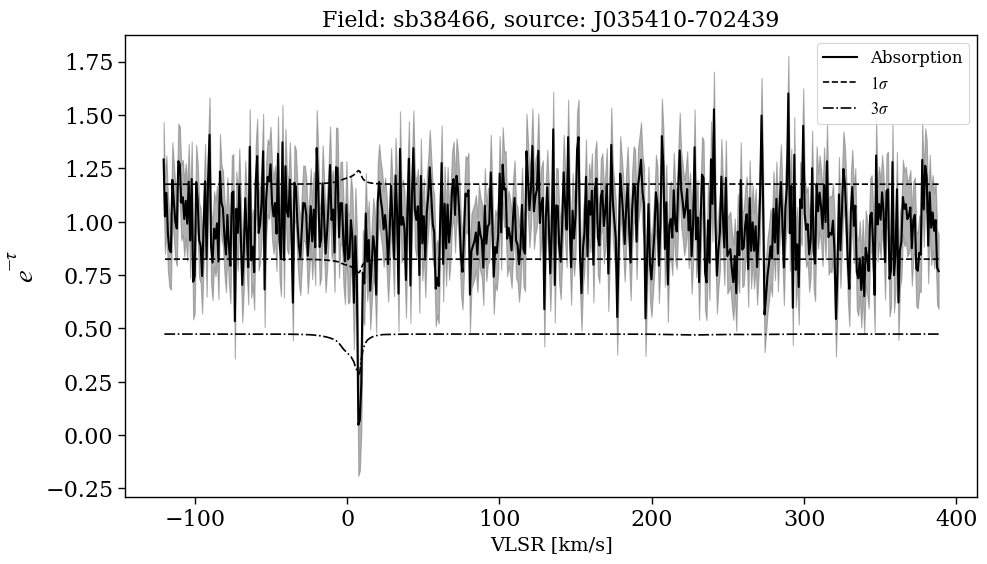

In [61]:
# Absorption profile
fcn.plot_absorption_profile(field, source, abs_vlsr, emt, emt_std)

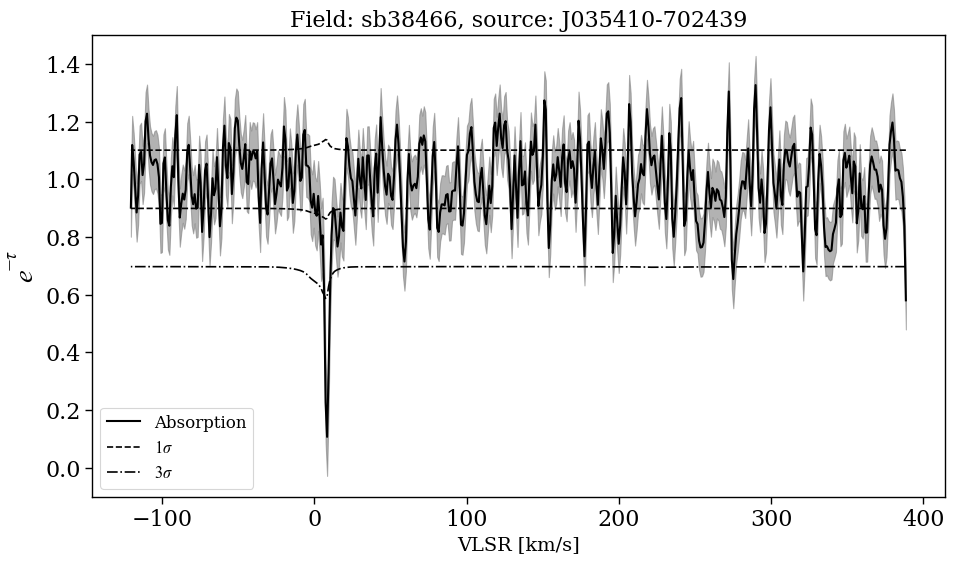

In [62]:
# Smoothed spectrum
fcn.plot_absorption_profile(field, source, abs_vlsr, emt_smooth, emt_std_smooth)

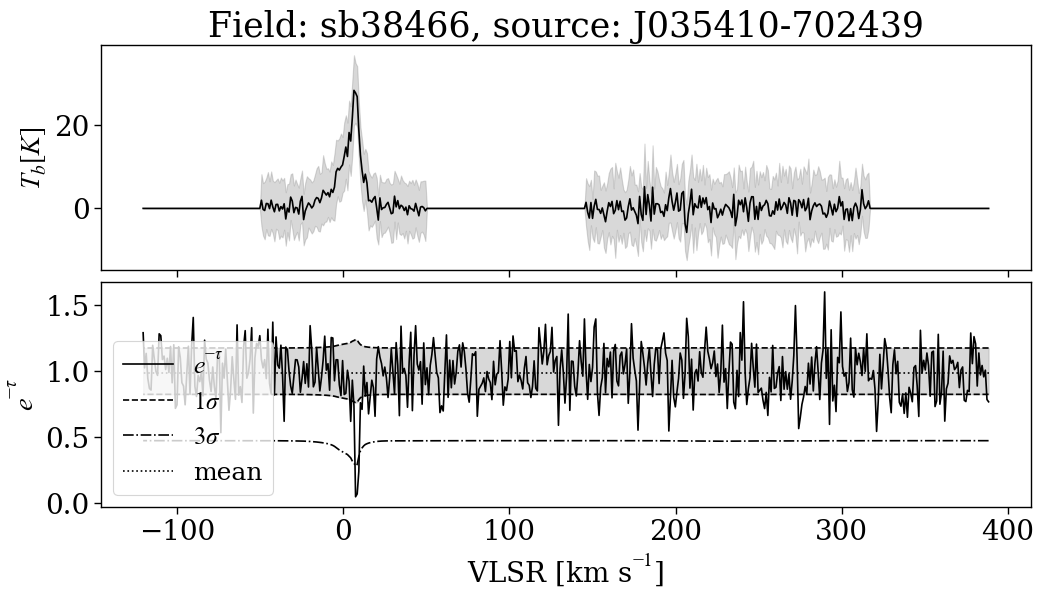

In [63]:
fcn.plot_em_abs(field, source, abs_vlsr, Tem, Tem_std, emt, emt_std)

# Abs. MW velocity range

In [127]:
# Read .csv for the MW foreground
filename = field_spectra_dir / (source + '_spec.csv')
data = pd.read_csv(filename)
print('Data shape:', data.shape)
data.head()

Data shape: (226, 8)


,velocity,em_mean,em_std,optical_depth,sigma_od,smoothed_od,sigma_smoothed_od,flux
0,99199.157604,0.0,0.0,0.938900,0.175567,0.989061,0.100980,0.000079
1,98221.987658,0.0,0.0,0.853339,0.175577,0.881585,0.100986,0.000072
2,97244.817712,0.0,0.0,0.880762,0.175567,0.839257,0.100980,0.000074
3,96267.647766,0.0,0.0,0.742165,0.175567,0.842255,0.100980,0.000062
4,95290.477820,0.0,0.0,1.003928,0.175567,0.995280,0.100980,0.000084


In [65]:
abs_vlsr = data['velocity'].values/1000.
Tem      = data['em_mean'].values
Tem_std  = data['em_std'].values
emt      = data['optical_depth'].values
emt_std  = data['sigma_od'].values
flux     = data['flux'].values
emt_smooth = data['smoothed_od'].values
emt_std_smooth = data['sigma_smoothed_od'].values

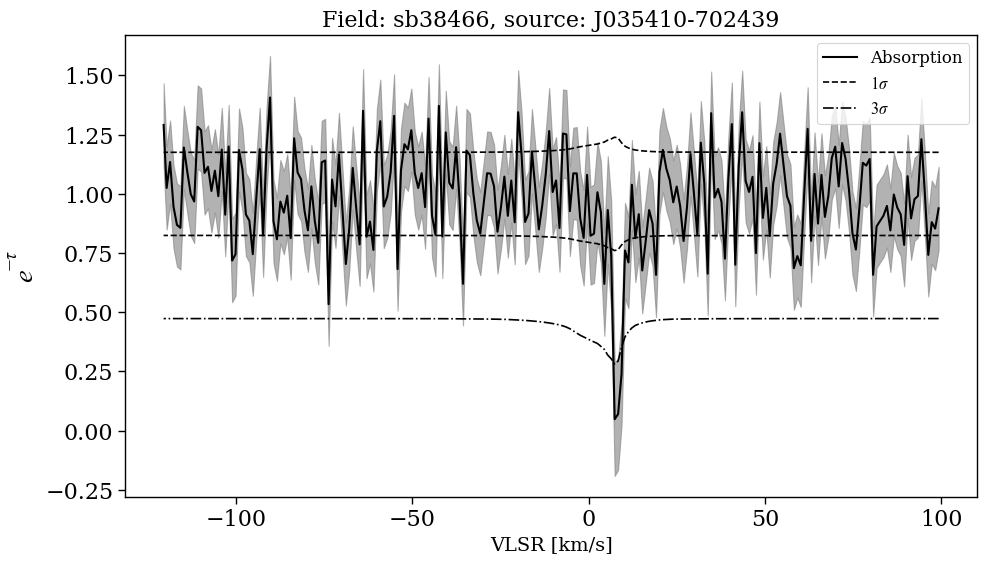

In [66]:
# Absorption profile
fcn.plot_absorption_profile(field, source, abs_vlsr, emt, emt_std)

# Read subcubes

Extract a subcube around a source with a radius of 60 arcseconds

In [ ]:
print(hires_em_profile_path)
print(hires_em_profile_path / field)
os.makedirs(hires_em_profile_path / field, exist_ok=True)

In [83]:
sid = 0
src = source
src_info = fcn.get_source_info_by_name(df, source)
field_id = src_info['sbid']
field    = 'sb' + str(field_id)

print(f"# {sid} -- Field {field}, Source: {src}, ID {src_info['id']}")

# Galactic coordinates
src_gl = src_info['glon']
src_gb = src_info['glat']
src_ra = src_info['ra']
src_dec = src_info['dec']
src_major = src_info['semi_maj_axis']
src_minor = src_info['semi_min_axis']
src_pa = src_info['pa']
flux_int = src_info['flux_int']
print('Field_id, Field: ', field_id, field)
print('Glon, Glat: ', src_gl, src_gb)
print('RA, DEC: ', src_ra, src_dec)
print('flux_int: ', flux_int)
print('Semi-major, semi-minor axes [arcseconds]: ', src_major, src_minor)

# 0 -- Field sb38466, Source: J035410-702439, ID 0
Field_id, Field:  38466 sb38466
Glon, Glat:  284.78010847924884 -39.6468628873173
RA, DEC:  58.542289 -70.411048
flux_int:  42.78099822998047
Semi-major, semi-minor axes [arcseconds]:  6.710000038146973 5.474999904632568


In [84]:
# save subcube of each source to files
GASKAP_subcube_dir = hires_em_data / 'subcubes' / field
subcube_filename   = GASKAP_subcube_dir / (src + '.fits')

sc, cube_wcs, subcube_ra, subcube_dec, subcube_vlsr, subcube_hdr = fcn.read_fits_cube(subcube_filename)
print(cube_wcs)
print(sc)

# save subcube of each source to files
GASKAP_subcube_dir = hires_em_data / 'subcubes' / field
subcube_filename   = GASKAP_subcube_dir / (src + '_smoothed.fits')

sc, cube_wcs,\
subcube_ra, subcube_dec,\
subcube_vlsr, subcube_hdr = fcn.read_fits_cube(subcube_filename)
print(cube_wcs)
print(sc)

Cube shape: (413, 50, 50)
WCS Keywords

Number of WCS axes: 3
CTYPE : 'RA---SIN'  'DEC--SIN'  'VRAD'  
CRVAL : 47.9318791667  -71.0418611111  63516.9930683  
CRPIX : 1845.0  -139.0  -53.0  
PC1_1 PC1_2 PC1_3  : 1.0  0.0  0.0  
PC2_1 PC2_2 PC2_3  : 0.0  1.0  0.0  
PC3_1 PC3_2 PC3_3  : 0.0  0.0  1.0  
CDELT : -0.00194444444444  0.00194444444444  -244.290806829  
NAXIS : 50  50  413
SpectralCube with shape=(413, 50, 50) and unit=K:
 n_x:     50  type_x: RA---SIN  unit_x: deg    range:    58.380418 deg:   58.710200 deg
 n_y:     50  type_y: DEC--SIN  unit_y: deg    range:   -70.466392 deg:  -70.355936 deg
 n_s:    413  type_s: VRAD      unit_s: m / s  range:   -50322.523 m / s:   50325.289 m / s


Cube shape: (104, 50, 50)
WCS Keywords

Number of WCS axes: 3
CTYPE : 'RA---SIN'  'DEC--SIN'  'VRAD'  
CRVAL : 47.9318791667  -71.0418611111  50325.289499534  
CRPIX : 1845.0  -139.0  1.0  
PC1_1 PC1_2 PC1_3  : 1.0  0.0  0.0  
PC2_1 PC2_2 PC2_3  : 0.0  1.0  0.0  
PC3_1 PC3_2 PC3_3  : 0.0  0.0  1.0  
CDELT : -0.00194444444444  0.00194444444444  -977.163227316  
NAXIS : 50  50  104
SpectralCube with shape=(104, 50, 50) and unit=K:
 n_x:     50  type_x: RA---SIN  unit_x: deg    range:    58.380418 deg:   58.710200 deg
 n_y:     50  type_y: DEC--SIN  unit_y: deg    range:   -70.466392 deg:  -70.355936 deg
 n_s:    104  type_s: VRAD      unit_s: m / s  range:   -50322.523 m / s:   50325.289 m / s


In [85]:
subcube_vlsr_arr = subcube_vlsr.value/1000.
print('Resolution in RA: ', np.diff(subcube_ra.value)[0]*3600, np.cos(np.radians(src_dec))*np.diff(subcube_ra.value)[0]*3600)
print('Resolution in DEC: ', np.diff(subcube_dec.value)[0]*3600)

Resolution in RA:  -20.62936280882184 -6.916404658722449
Resolution in DEC:  6.890101600561138


In [87]:
# Some info of the source
# The GASKAP pixel size is 7 arcsec (don't forget the cos(DEC) factor)
nchan = len(subcube_vlsr_arr)

n_ra = len(subcube_ra)
n_dec = len(subcube_dec)
Npix = n_ra*n_dec

print('Resolution in RA: ',
      np.diff(subcube_ra.value)[0]*3600, 'arcsec',
      np.cos(np.radians(src_dec))*np.diff(subcube_ra.value)[0]*3600, 'arcsec'
     )
print('Resolution in DEC: ', np.diff(subcube_dec.value)[0]*3600, 'arcsec')
print('Number of channels: ', nchan)

Resolution in RA:  -20.62936280882184 arcsec -6.916404658722449 arcsec
Resolution in DEC:  6.890101600561138 arcsec
Number of channels:  104


RA shape: (50, 50)
DEC shape: (50, 50)


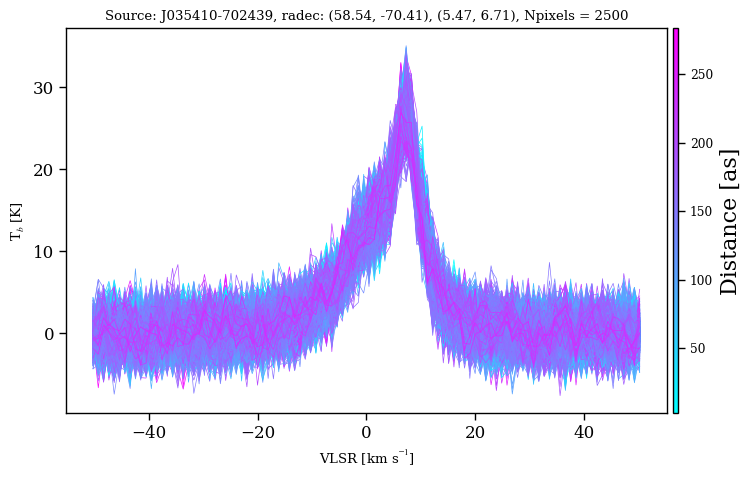

In [88]:
# Calculte the angular distances within the subcube
X_ra, Y_dec = np.meshgrid(subcube_ra.value, subcube_dec.value, indexing='ij')

print(f'RA shape: {X_ra.shape}')
print(f'DEC shape: {Y_dec.shape}')

fcn.plot_em_profiles_with_distances(X_ra, Y_dec,
                                        subcube_vlsr_arr, sc,
                                        src_ra, src_dec,
                                        src, src_minor, src_major,
                                        Npix
                                       )

In [89]:
## Here I compute the average spectrum of the subcube
subcube = sc.unmasked_data[:,:,:].value
subcube = np.nan_to_num(subcube)
avg_spec, n_specs = fcn.get_avg_spec(subcube)

In [90]:
## Here I find the candidates for emission spectra around a source.
## I do that because the noise in GASKAP emission cube is high, 
# and the emission spectra near a continuum source are likely to be contaiminated by the absorption.
# In "get_spec_candidates()", you can change the threshold as you wish.
# Here I compare each emission spectrum with the average spectrum to select the candidates.
em_candidates, n_specs = fcn.get_spec_candidates(subcube, avg_spec)

In [92]:
# Here I will plot all the pixels on a map
X_ra, Y_dec = np.meshgrid(subcube_ra.value, subcube_dec.value, indexing='ij')

print(f'RA shape: {X_ra.shape}')
print(f'DEC shape: {Y_dec.shape}')
RD_meshgrid_shape = X_ra.shape
X_ra_arr = X_ra.ravel()
Y_dec_arr = Y_dec.ravel()
RD_arrays = np.c_[X_ra.ravel(), Y_dec.ravel()]

RA shape: (50, 50)
DEC shape: (50, 50)


In [93]:
# Moment m0 map of the subcube
m0_subecube_file = GASKAP_subcube_dir / (src + '_smoothed_m0.fits')
print(m0_subecube_file)
subcube_m0, subcube_m0wcs = fcn.moment0_map(sc, m0_subecube_file)

# Convert Moment_0 to a Column Density assuming optically thin media
subcube_nhi = 1.e-20 * subcube_m0 * 1.8224 * 1.e18 / (u.cm * u.cm) * u.s / u.K / u.km
subcube_nhi = subcube_nhi.value
print(subcube_m0.shape)
print(subcube_m0wcs)

/Users/kiemhiep/ANU/ASKAP/data/LMC/hires/cube/subcubes/sb38466/J035410-702439_smoothed_m0.fits


(50, 50)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---SIN'  'DEC--SIN'  
CRVAL : 47.9318791667  -71.0418611111  
CRPIX : 1845.0  -139.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -0.00194444444444  0.00194444444444  
NAXIS : 50  50


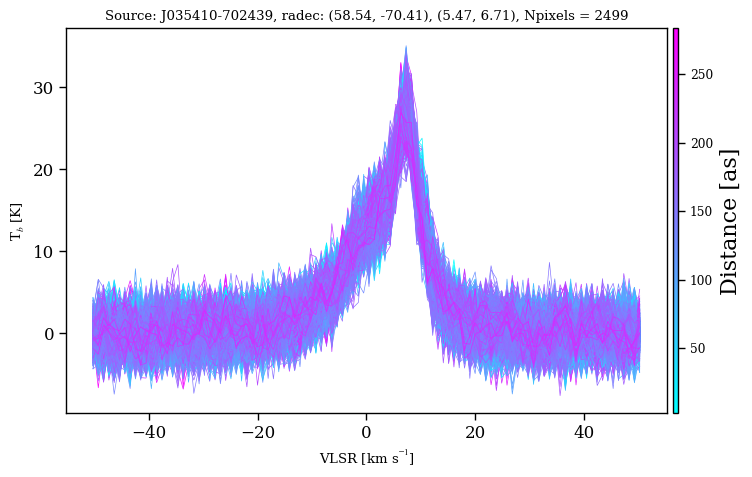

In [100]:
# Here I plot all the candidates of emission spectra color-coded by their angular distances (in arcsec) to the source
fcn.plot_em_profiles_with_distances(X_ra, Y_dec,
                                    subcube_vlsr_arr,
                                    em_candidates,
                                    src_ra, src_dec,
                                    src,
                                    src_minor,
                                    src_major,
                                    n_specs
                                   )

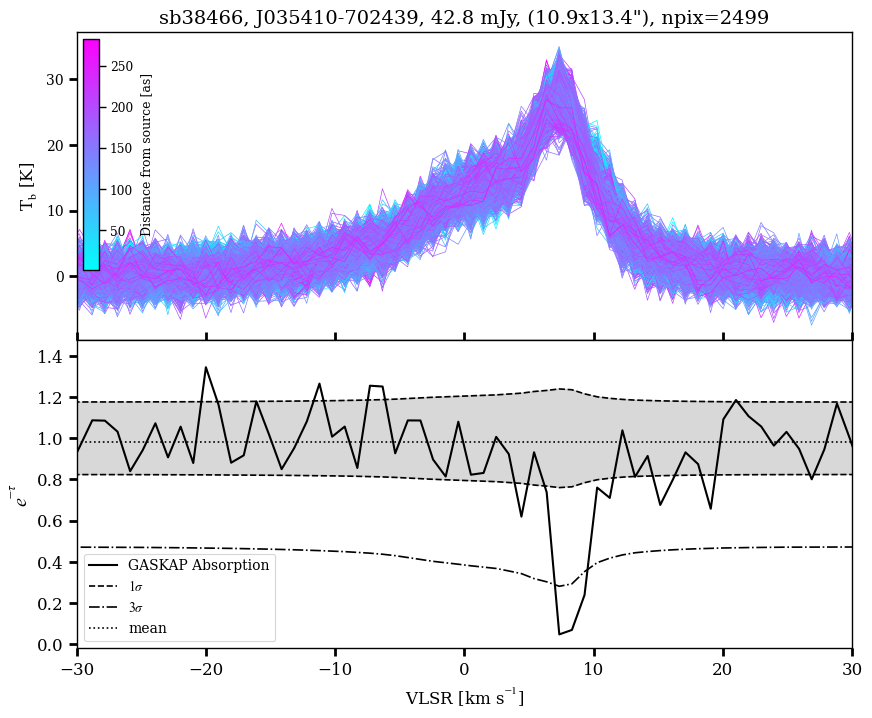

In [101]:
# Here I plot all the candidates of emission spectra color-coded by their angular distances (in arcsec) to the source
# I also plot the emission and absorption profiles
fcn.plot_gaskap_em_abs(X_ra, Y_dec,
                       subcube_vlsr_arr,
                       em_candidates,
                       abs_vlsr, emt, emt_std,
                       src_ra, src_dec,
                       field,
                       src,
                       src_minor,
                       src_major,
                       flux_int,
                       n_specs
                      )

# Emission profiles around a source

Now we will extract the emission profiles around a source.

1 emission spectrum / beam

GASKAP beam = 30 arcsec

In [103]:
# Meshgrid
RA, DEC = np.meshgrid(subcube_ra.value, subcube_dec.value, indexing='ij')

In [104]:
print(f'RA shape: {RA.shape}')
print(f'DEC shape: {DEC.shape}')
RADEC_meshgrid_shape = RA.shape
RADEC_arrays = np.c_[RA.ravel(), DEC.ravel()]

RA shape: (50, 50)
DEC shape: (50, 50)


In [105]:
xc_ = (RA - src_ra)*3600.
yc_ = (DEC - src_dec)*3600.

# Calc. distances
d0_ = np.sqrt(xc_**2 + yc_**2)
np.where(d0_ < 120.)[0].shape

(321,)

In [ ]:
rmin = 15./3600.   # 15 arsec to degrees
rmax = 120./3600.  # 120 arcsec to degrees

# This function will extract about 20 emission spectra around a source
# 1 spectrum / beam
indices, distances, X_ra, Y_dec,\
idx_nearest, x_nearest, y_nearest,\
dnearest = fcn.get_em_profiles_annulus(RADEC_arrays,
                                       RADEC_meshgrid_shape,
                                       rmin,
                                       rmax,
                                       src_ra,
                                       src_dec,
                                       em_candidates
                                      )
npixels = len(indices)
print(f"Number of pixels with distances > 15'' ({np.round(rmin,4)} [deg]): {npixels}")

In [107]:
print('Index (in 1D) and distance (in degrees) of the nearest spectrum:')
print(idx_nearest, dnearest)
print()
print('Indices (in 2D) of the nearest spectrum:')
id_xy_nearest = np.unravel_index(idx_nearest, RADEC_meshgrid_shape)
print(id_xy_nearest)

ra_val_closest = X_ra_arr[idx_nearest]
dec_val_closest = Y_dec_arr[idx_nearest]

Index (in 1D) and distance (in degrees) of the nearest spectrum:
1470 0.0006833114674413646

Indices (in 2D) of the nearest spectrum:
(29, 20)


Plot the spectrum of the closest pixel

In [108]:
# Spectrum: the nearest pixel to the source (will be excluded)
em_spectrum_nearest = subcube[:, id_xy_nearest[1], id_xy_nearest[0]]
print(f'Length of Tb (or number of velocity channels): {len(em_spectrum_nearest)} channels')

Length of Tb (or number of velocity channels): 104 channels


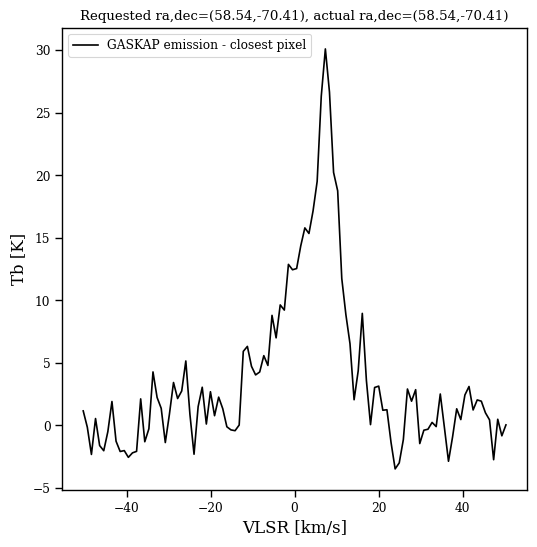

In [109]:
# Her I plot the closest emission spectrum to the source
plt.figure(figsize=(6,6))

plt.plot(subcube_vlsr_arr, em_spectrum_nearest, 'k-', label='GASKAP emission - closest pixel')
plt.title(f'Requested ra,dec=({round(src_ra, 2)},{round(src_dec, 2)}), actual ra,dec=({round(ra_val_closest, 2)},{round(dec_val_closest, 2)})')


plt.xlabel('VLSR [km/s]', fontsize=12)
plt.ylabel('Tb [K]', fontsize=12)


plt.legend(loc='upper left')
plt.show()

## Find the neigbouring pixels

Find the neigbouring pixels, the GASKAP primary beam (30 arcsecs, rmin = 15 arcsecs).

I will exclude 1 beam around the source.

In [110]:
# To 2D indices
idx_pairs = np.unravel_index(indices, RADEC_meshgrid_shape)

# Take the differences (of pixels) in X and Y axes
XX = idx_pairs[0] - id_xy_nearest[0]
YY = idx_pairs[1] - id_xy_nearest[1]

In [112]:
# Circle of GASKAP beam
rbeam = 15.
xbeam,ybeam = fcn.beam_radec(rbeam, src_ra, src_dec)

rmax = 40.
xrmax,yrmax = fcn.beam_radec(rmax, src_ra, src_dec)

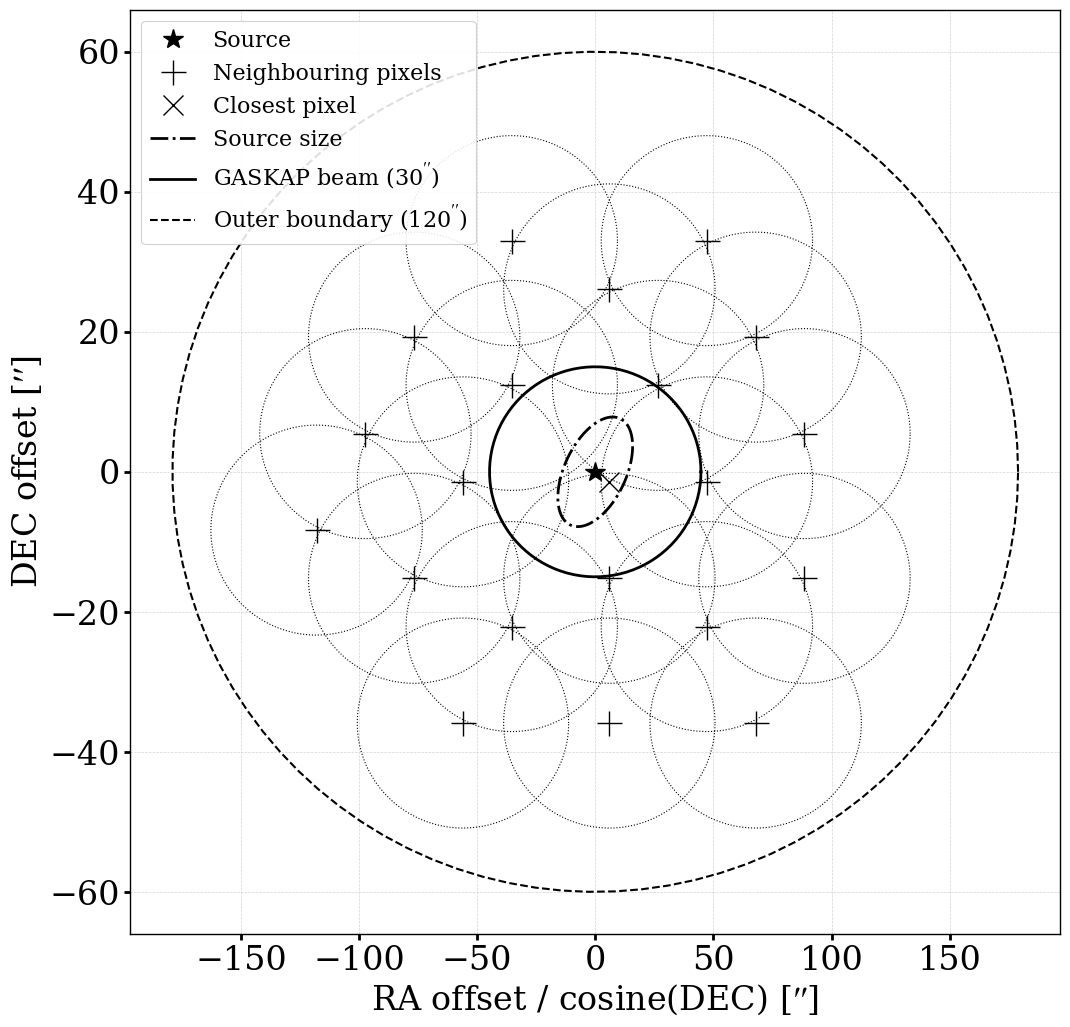

In [113]:
# Plot selected pixels around a source with beam circles
# fcn.plot_selected_em_pixels_on_maps
fcn.plot_selected_em_pixels_on_map_offset(field, src,
                                           X_ra, Y_dec,
                                           src_ra, src_dec,
                                           ra_val_closest,
                                           dec_val_closest,
                                           radius_wid,
                                           radius_hgh, src_pa,
                                           subcube_nhi,
                                           subcube_m0wcs
                                          )

In [114]:
# Select good spectra
em_spectra = np.zeros((npixels, nchan))

print('Number of emission spectra around a source, and number of velocity channels:', em_spectra.shape)
for k, (i,j) in enumerate(zip(idx_pairs[0], idx_pairs[1])):
    em_spectra[k, :] = em_candidates[:, j, i]

print(f'Emission spectra shape: {em_spectra.shape}')

Number of emission spectra around a source, and number of velocity channels: (20, 104)
Emission spectra shape: (20, 104)


In [115]:
# Transpose: row = velocity channels, column = emission spectra
em_spectra = em_spectra.T
nchan, nspec = em_spectra.shape
print(f'Emission_spectra shape: {em_spectra.shape}')
print(nchan, nspec )

Emission_spectra shape: (104, 20)
104 20


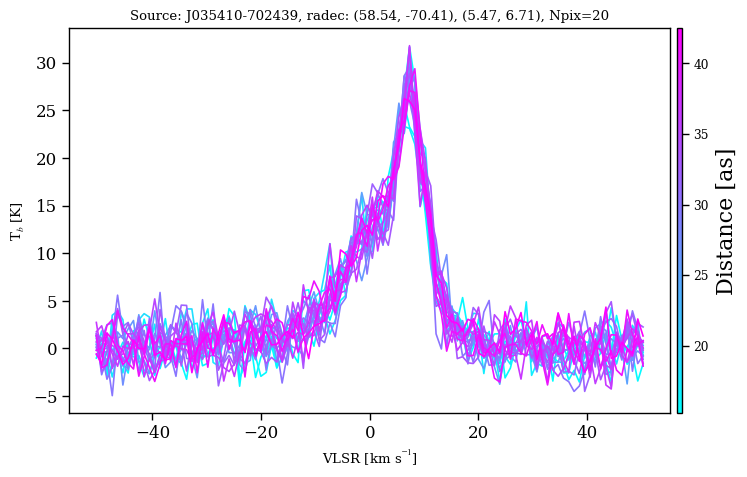

In [117]:
# Here I plot the selected emission spectra around a source, colour-coded by the angular distances to the center.
fcn.plot_selected_em_profiles_with_distances(X_ra, Y_dec,
                                             subcube_vlsr_arr,
                                             em_spectra,
                                             src_ra, src_dec,
                                             src,
                                             src_minor,
                                             src_major
                                            )

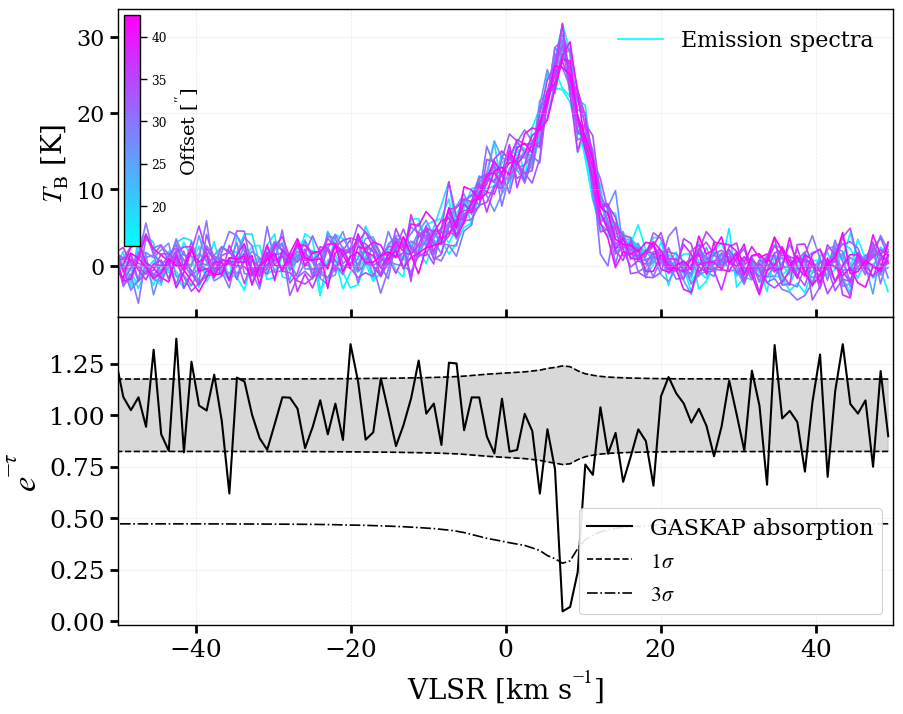

In [119]:
# Here I plot the selected emission spectra around a source, colour-coded by the angular distances to the center.
# Also the absorption profile
fcn.plot_gaskap_selected_em_abs(X_ra, Y_dec,
                                subcube_vlsr_arr, 
                                em_spectra,
                                abs_vlsr, emt, emt_std,
                                src_ra, src_dec,
                                field,
                                src,
                                src_minor,
                                src_major,
                                flux_int
                               )

# End